# Practice Case Social Media Analysis with SPARK
## by Febi Andika Dani Fajar Suryawan

## Background

Pada practice case kali ini digunakan data clean_tweet.csv yang berisi dua kolom yaitu kolom text yang berisi data tweet dari pengguna twitter dan kolom target yang berisi label sentimen dari tiap tweet ("0" berarti sentimen negatif dan "1" berarti sentimen positif). Selanjutnya dilakukan data preprocessing, data exploration dan feature extraction untuk membuat model klasifikasi yang dapat digunakan untuk menentukan kategori sentimen dari setiap tweet baru.

## Import Library

In [1]:
import pandas as pd 
import numpy as np

#Authentication module. for documentation  (http://docs.tweepy.org)
import tweepy as tp

#import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import reguler expression 
import re

#import textblob 
from textblob import TextBlob

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\febian064178\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\febian064178\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Preparation

### 1. Load Dataset

In [2]:
df=pd.read_csv('clean_tweet.csv')
df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


### 2. Check Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
df.shape

(1600000, 2)

***
Data clean_tweet.csv terdiri dari 1600000 baris dan 2 kolom
***

### 3. Check Missing Value

In [5]:
# Check missing value
df.isna().sum()

text      3247
target       0
dtype: int64

***
Terdapat sebanyak 3247 nilai yang hilang pada kolom text, selanjutnya akan dilakukan penghapusan pada baris yang hilang
***

### 4. Drop Missing Value

In [6]:
# Drop missing value
df=df.dropna()
df.isna().sum()

text      0
target    0
dtype: int64

### 5. Change sentiment value "0" to "Negative" and "1" to "Positive"

In [7]:
# Change sentiment value
df["target"]=np.where(df["target"]==0,"Negative","Positive")

## Data Preprocessing

Data text tweet yang diberikan sudah lumayan bersih dan baik (data sudah seragam/tidak ada huruf kapital dan sudah tidak terdapat punctuation), hanya saja masih diperlukan beberapa proses untuk merapikan dan membersihkan data sebelum melakukan modelling antara lain stopwords removal, lemmatization, dan frequent words removal.

### 1. Stopwords removal

Proses ini dilakukan untuk menghilangkan kata-kata yang dianggap tidak memiliki makna di dalam kalimat.

In [8]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head(10)

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                               k nope
9                                            que muera
Name: text, dtype: object

### 2. Lemmatization

Proses ini dilakukan untuk menjadikan suatu kata menjadi kata dasarnya.

In [9]:
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### 3. Frequent words removal

Proses ini dilakukan untuk menampilkan kata yang paling banyak muncul/ paling banyak terdapat pada data. Selanjutnya dilakukan langkah untuk menghapus beberapa kata yang paling banyak muncul tetapi tidak memiliki makna.

In [10]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:8]
freq

day      109292
good      91468
get       86475
like      79913
go        78561
u         70836
today     68713
work      68655
dtype: int64

In [11]:
freq = ["day","get","today","u","going","got","one","time"]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:8]
freq

good    91468
like    79913
go      78561
work    68655
love    68489
lol     59276
back    57110
know    54114
dtype: int64

## Data Exploration

### 1. Plotting the number of each type of sentiments

C:\Users\febian064178\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0,0.5,'Number in %')

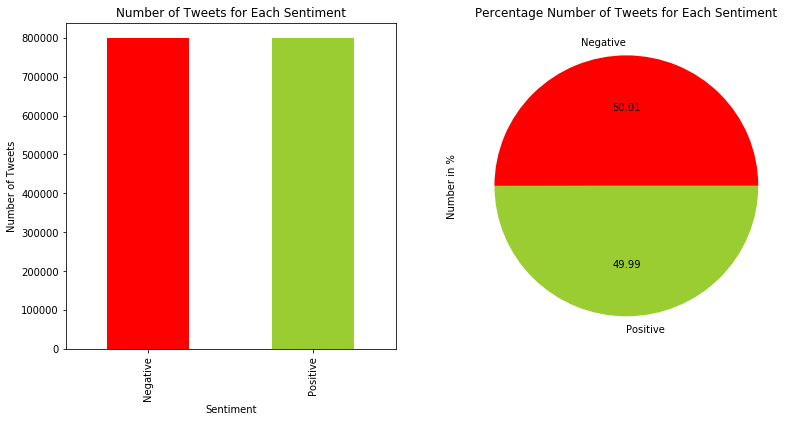

In [29]:
#Plotting the number of each type of sentiments 
f=plt.figure(figsize=(13,6))

f.add_subplot(1,2,1)
colors=["red","yellowgreen"]
pd.Series(df["target"]).value_counts().plot(kind="bar",colors=colors,title = "Number of Tweets for Each Sentiment")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

f.add_subplot(1,2,2)
colors=["red","yellowgreen"]
pd.Series(df["target"]).value_counts().plot(kind="pie",colors=colors,labels=["Negative", "Positive"],autopct='%.2f',title = "Percentage Number of Tweets for Each Sentiment")
plt.ylabel('Number in %')

***
Dari data text twitter diatas diketahui bahwa perbandingan antara banyaknya tweet yang mengandung sentimen negatif dengan sentimen positif memiliki nilai yang relatif sama. 
***

### 2. Wordcloud

In [13]:
#group the data for each sentiment
Negative = df.loc[df['target'] == "Negative"]
Positive = df.loc[df['target'] == "Positive"]

#make text set for each sentiment
all_desc_negative = "".join(Negative.text.values)
all_desc_positive = "".join(Positive.text.values)

### 2.1. Positive sentiment wordcloud

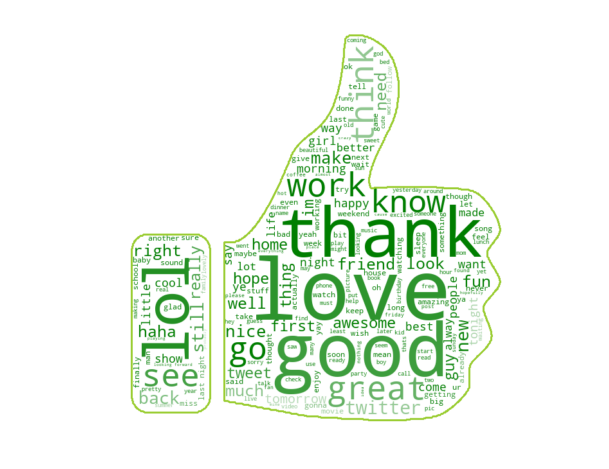

In [31]:
mask = np.array(Image.open("thumbup.png"))
colors=ImageColorGenerator(mask)
cloud = WordCloud(background_color = "white", mask = mask, color_func = colors, contour_width = 2, contour_color = 'yellowgreen', max_words = 200, stopwords = set(STOPWORDS)).generate(all_desc_positive)
cloud.to_file("thumbup_new.png")
plt.figure(figsize = (15, 8))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

***
Dari wordcloud diatas dapat dilihat bahwa kata thank, love dan good adalah tiga kata yang frekuensinya paling banyak digunakan untuk membuat tweet dengan sentimen positif. Hal ini menggambarkan bahwa tweet yang memiliki sentimen positif merupakan tweet yang berisi kata-kata yang mengandung ungkapan ucapan terima kasih, kasih sayang, senang hingga pujian.
***

### 2.2. Negative sentiment wordcloud 

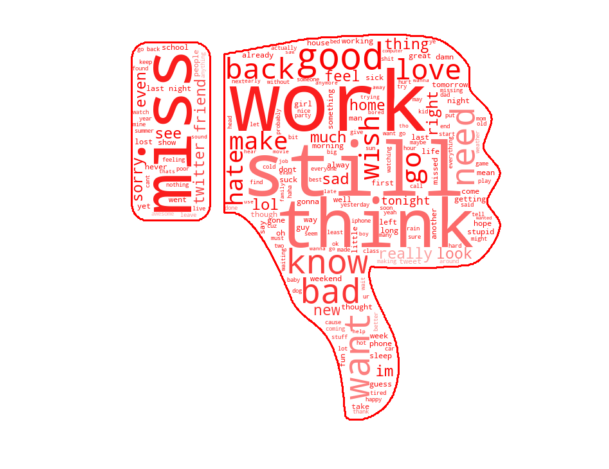

In [35]:
mask = np.array(Image.open("thumbdown.png"))
colors=ImageColorGenerator(mask)
cloud = WordCloud(background_color = "white", mask = mask, color_func = colors, contour_width = 2, contour_color = 'red', max_words = 200, stopwords = set(STOPWORDS)).generate(all_desc_negative)
cloud.to_file("thumbdown_new.png")
plt.figure(figsize = (15, 8))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

***
Dari wordcloud diatas dapat dilihat bahwa kata still, work dan miss adalah tiga kata yang frekuensinya paling banyak digunakan untuk membuat tweet dengan sentimen negatif. Hal ini menggambarkan bahwa tweet yang memiliki sentimen negatif merupakan tweet yang berisi kata-kata yang mengandung ungkapan perasaan lelah (still work), rindu, hingga benci.
***

## Modelling

### 1. Feature Extraction

* Count Vectorizer digunakan untuk mengonversi text menjadi vektor jumlah/banyak kata
* TF-IDF Vectorizer digunakan untuk mengonversi text menjadi vektor frekuensi dari tiap data

In [16]:
# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

In [17]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

### 2. Train Test Split

In [18]:
X = df["text"]
y = df["target"]

In [19]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [20]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y_v, test_y_v = train_test_split(X_vectorizer, y, test_size = 0.2, random_state = 0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size = 0.2, random_state = 0)

### 3. Model Machine Learning
* 3.1 Logistic Regression
* 3.2 Naive Bayes

### 3.1 Logistic Regression

In [21]:
# Countvectorizer
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer, train_y_v)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)
pred_y_v = Lr_vect.predict(test_X_vectorizer)
print(pred_y_v)

['Negative' 'Negative' 'Negative' ... 'Positive' 'Negative' 'Positive']


In [22]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)
pred_y = Lr_vect.predict(test_X_tfidf)
print(pred_y)

['Negative' 'Negative' 'Negative' ... 'Positive' 'Negative' 'Positive']


### 3.2 Naive Bayes

In [23]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [24]:
# TFIDFVectorizer
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

### 4. Model Evaluation
The following option are kind of model evaluation that used:

* Precision = precision_score()
* Recall = recall_score()
* F_measure = f1_score()

### 4.1 Logistic Regression

In [25]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_recall_vec_train = recall_score(train_y_v, Lr_pred_vect_train, average = "micro")
Lr_recall_vec_test = recall_score(test_y_v, Lr_pred_vect_test,average = "micro") 

Lr_precision_vec_train = precision_score(train_y_v, Lr_pred_vect_train,average = "micro")
Lr_precision_vec_test = precision_score(test_y_v, Lr_pred_vect_test,average = "micro")

Lr_f1_score_vec_train = f1_score(train_y_v, Lr_pred_vect_train,average = "micro")
Lr_f1_score_vec_test = f1_score(test_y_v, Lr_pred_vect_test,average = "micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 80.25% & 76.98%
Precision train & test  : 80.25% & 76.98%
F1 Score train & test   : 80.25% & 76.98%


In [26]:
# using TF-IDF vectorizer
print("______________ TF-IDF ______________")

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y, Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 79.48% & 77.10%
Precision train & test  : 79.48% & 77.10%
F1 Score train & test   : 79.48% & 76.98%


### 3.2 Naive Bayes

In [27]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")


NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 79.09% & 76.21%
Precision train & test  : 79.09% & 76.21%
F1 Score train & test   : 79.09% & 76.21%


In [28]:
# using count vectorizer
print("______________ TF-IDF ______________")


NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 79.13% & 75.63%
Precision train & test  : 79.13% & 75.63%
F1 Score train & test   : 79.13% & 76.21%


### 4. Model Selection
Berdasarkan hasil perbandingan dua algoritma diatas, diperoleh bahwa algoritma yang memberikan hasil paling baik adalah Logistic Regression dengan Count Vectorizer sebagai feature extraction dengan nilai Recall train & test: 80.25% & 76.98%, Precision train & test: 80.25% & 76.98% dan F1 Score train & test: 80.25% & 76.98%. Dapat dilihat dari ketiga nilai tersebut bahwa hasil klasifikasi dengan menggunakan logistic regression sudah cukup baik untuk memprediksi sentimen dari data text twitter. Hanya saja hasil ini belum dapat dibilang cukup valid dikarenakan adanya keterbatasan dalam menentukan parameter dari algoritma yang digunakan dan penggunaan algoritma lain yang tidak dapat dilakukan dikarenakan keterbatasan memori perangkat dalam memproses data yang besar.


## Conclusion
***
Dalam hal bisnis, sentiment analysis dapat dimanfaatkan untuk kepentingan kemajuan bisnis perusahaan. Sentiment analysis dapat digunakan untuk mengetahui reaksi atau testimoni dari pelanggan mengenai produk/layanan yang dimiliki oleh perusahaan. Andaikan data tweet diatas merupakan testimoni dari pelanggan perusahaan kita yang dituangkan melalui twitter, maka perusahaan dapat mengetahui bagaimana penilaian pelanggan terhadap produk/layanan yang diberikan oleh perusahaan. Saat semakin banyak sentimen positif dari pelanggan tentunya hal tersebut dapat meningkatkan branding perusahaan kita. Sedangkan semakin banyak sentimen negatif dari pelanggan tentunya dapat digunakan untuk meningkatkan pelayanan perusahaan atau meningkatkan kualitas produk. Dari kata-kata yang terkandung pada setiap tweet perusahaan juga dapat tahu sektor mana yang harus ditingkatkan atau diperbaiki.
***